In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterSampler
import hdbscan

from scipy.spatial.distance import cdist
from scipy.stats import randint
import clustering

In [136]:
from IPython.core.interactiveshell import InteractiveShell
from importlib import reload
reload(clustering)
from clustering import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

InteractiveShell.ast_node_interactivity = 'all'
sns.set()
sns.set(rc={'figure.figsize':(12,8)})

<module 'clustering' from 'C:\\Users\\LCI_user\\Documents\\GitHub\\LCI-Clustering\\clustering.py'>

## Loading Data

In [3]:
df = pd.read_csv('Diskovery_Cell1_ThunderSTORM.csv')
df.head()
df = df.sort_values(by=['intensity [photon]'])

,id,frame,x [nm],y [nm],sigma [nm],intensity [photon],offset [photon],bkgstd [photon],uncertainty [nm]
0,1.0,1.0,2474.998618,6736.088180,195.815722,1841.965445,80.087915,10.501425,9.781846
1,2.0,1.0,4356.136836,14133.322371,145.009192,5599.702004,82.962749,24.851702,4.184589
2,3.0,1.0,4542.775300,9091.265025,121.313419,221.442108,39.507939,4.162599,15.045367
3,4.0,1.0,5977.444344,7594.973438,137.276419,155.518749,39.499220,4.681645,24.730111
4,5.0,1.0,6079.459555,11231.168432,137.261612,2693.631410,59.415820,11.278048,4.647010


## Displaying Raw Data

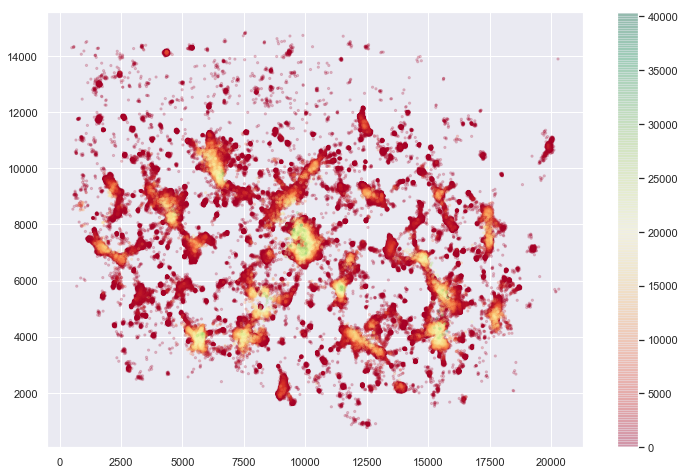

In [5]:
img = plt.scatter(df['x [nm]'],
                  df['y [nm]'],
                  c=df['intensity [photon]'],
                  s=5, cmap='RdYlGn',alpha=0.2)
_ = plt.colorbar(img)

## HDBSCAN

In [24]:
XY = df[['x [nm]', 'y [nm]']].sample(frac=0.2, random_state=1234).values

param_dist = {"min_cluster_size": randint(800, 1100),
              "min_samples": randint(600, 900)} # "alpha": np.round(np.linspace(0.1,2,100),2)
    
results = random_search_custom_hdb(param_dist,XY,n=2000)
results.head(10)

100%|███████████████████████████████████| 1987/1987 [14:46:54<00:00, 26.94s/it]


,score,min_cluster_size,min_samples
319,0.437,1089,629
831,0.437,1090,629
1579,0.437,1052,629
769,0.437,1056,631
1130,0.437,1066,631
1962,0.437,1059,611
508,0.437,1096,629
1577,0.437,1030,629
327,0.437,1073,611
1706,0.437,1032,631


In [ ]:
# results.to_csv('Hyper-param-search3.csv', index=0)
results.plot.scatter('min_cluster_size', 'min_samples', c='score', cmap='RdYlGn')

In [37]:
XY = df[['x [nm]', 'y [nm]']].sample(frac=0.2, random_state=1234).values

hdb = hdbscan.HDBSCAN(core_dist_n_jobs=6,min_cluster_size=1090,min_samples=629,gen_min_span_tree=True)
_ = hdb.fit(XY)
# hdb.relative_validity_

0.43672972146224687

In [ ]:
dbscan_verbose(hdb, XY, plot=True,p=0.05)

In [ ]:
view_cluster(hdb,XY,46,p=0.1)

c:\users\lci_user\miniconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\users\lci_user\miniconda3\lib\site-packages\mpl_scatter_density\generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


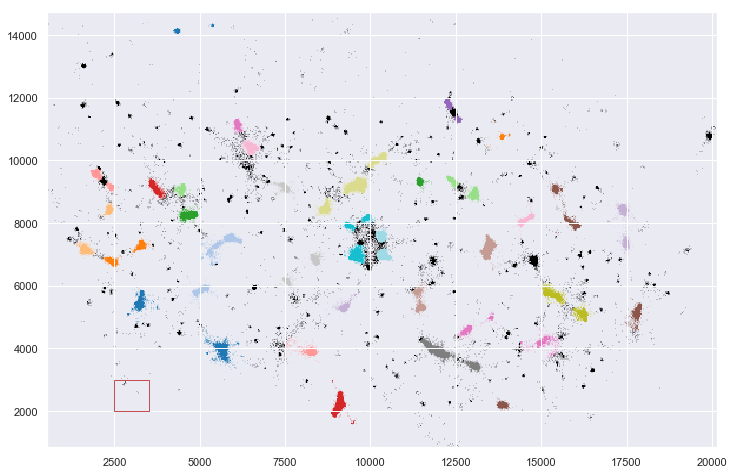

In [137]:
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
dbscan_verbose_lite(hdb, XY, p=0.0, ax=ax)

rect = patches.Rectangle((2500,2000),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
# rect.remove()